# Lyhimmän reitin analyysi

Jatketaan aiempaa Open Street Map -esimerkkiä ja tutkitaan edelleen Tampereen keskustorin ympäristöä. Tällä kertaa tavoitteenamme on tehdä yksinkertainen lyhimmän reitin analyysi. Selvitetään kartan pohjoisin piste ja haetaan lyhin reitti keskustorilta tähän pisteeseen. Tutkitaan vaihtelun vuoksi aluetta 500 metrin etäisyydellä keskustorista.

Aloitetaan tuomalla tarvittavat kirjastot [osmnx](https://osmnx.readthedocs.io/en/stable/) ja [matplotlib](https://matplotlib.org/) sekä hakemalla katuverkoston kuvaajaan tarvittavat tiedot aiemman esimerkin tapaan [`ox.graph_from_address()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_address)-funktiolla. Lisätään funktiolle vielä parametri `network_type='drive'`, jolloin saamme tiedot sellaisista kaduista, jotka ovat tarkoitettu autolla ajamista varten.

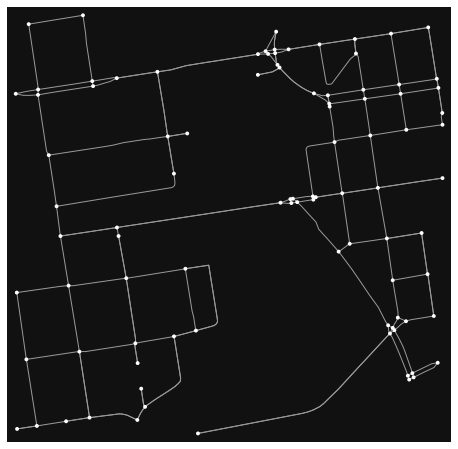

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt

address = "Keskustori 1, 33100, Tampere, Finland"
distance = 500 # metriä
graph = ox.graph_from_address(address, dist=distance, network_type='drive')
ox.plot_graph(graph) # Katsotaan, miltä katuverkosto näyttää

Haetaan seuraavaksi tieverkoston risteyskohdat ja tiet [`ox.graph_to_gdfs()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_to_gdfs)-funktiolla. Määritellään myös reittimme alku- ja loppupisteet. Valitaan alkupisteeksi lähimpänä kartan keskustaa oleva risteyspiste (node) ja loppupisteeksi kartan pohjoisin risteyspiste. Alkupisteen selvittämiseksi voimme laskea pienimmän alueen, joka sisältää koko tieverkostomme käyttäen [`unary_union`](https://geopandas.org/geometric_manipulations.html#GeoSeries.unary_union)- ja [`convex_hull`](https://geopandas.org/geometric_manipulations.html#GeoSeries.convex_hull)-metodeja. Lopulta alueen keskipiste saadaan [`centroid`](https://geopandas.org/geometric_manipulations.html#GeoSeries.centroid)-metodilla

In [2]:
nodes, edges = ox.graph_to_gdfs(graph)

area_union = edges.unary_union
convex_hull = area_union.convex_hull
centroid = convex_hull.centroid

Alueen keskipisteen koordinaatit on nyt tallennettu "centroid"-muuttujaan. Selvitetään seuraavaksi reitin päätepiste, eli karttamme pohjoisin risteyspiste. Katsotaan ensin, mitä risteyspisteitä sisällään pitävä "nodes"-geodataframe pitää sisällään.

In [3]:
nodes.head()

,y,x,highway,street_count,geometry
osmid,,,,,
27674461,61.497299,23.754825,traffic_signals,4,POINT (23.75483 61.49730)
27674462,61.497475,23.757272,NaN,3,POINT (23.75727 61.49748)
31861820,61.501607,23.770738,NaN,3,POINT (23.77074 61.50161)
33050117,61.494416,23.769856,NaN,4,POINT (23.76986 61.49442)
33136734,61.495456,23.769003,NaN,3,POINT (23.76900 61.49546)


Löydämme pohjoisimman pisteen etsimällä pisteen, jonka y-koordinaatti on kaikista suurin. Varmistetaan ensin, että kaikki y-koordinaatit ovat numeerisessa muodossa ja lasketaan sitten suurin y-koordinaatti [`max()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.max.html)-metodilla

In [4]:
nodes['y'] = nodes['y'].astype(float)
max_y = nodes['y'].max()

Nyt, kun tiedämme maksimi y-koordinaatin, voimme vielä etsiä kyseisen pisteen [`loc()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html)-metodilla. Tallennetaan alku- ja loppupisteiden koordinaatit vielä muuttujiin "orig_xy" ja "target_xy".

In [5]:
dest = nodes.loc[nodes['y']==max_y, 'geometry'].values[0]

# Tallennetaan alku- ja loppupisteiden koordinaatit
orig_xy = (centroid.y, centroid.x)
dest_xy = (dest.y, dest.x)

Etsitään lopuksi vielä alku- ja loppupistettämme lähimpänä olevan risteyspisteen indeksit, joiden avulla teemme lyhimmän reitin analyysin. Tämä onnistuu [`ox.get-nearest_node()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node)-funktiolla.

In [6]:
orig_node = ox.get_nearest_node(graph, orig_xy)
dest_node = ox.get_nearest_node(graph, dest_xy)

Lopulta voimme selvittää lyhimmän reitin pisteiden välillä [`ox.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.shortest_path)-funktiolla ja piirtää sen kartalle [`ox.plot_graph_route()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph_route)-funktiolla.

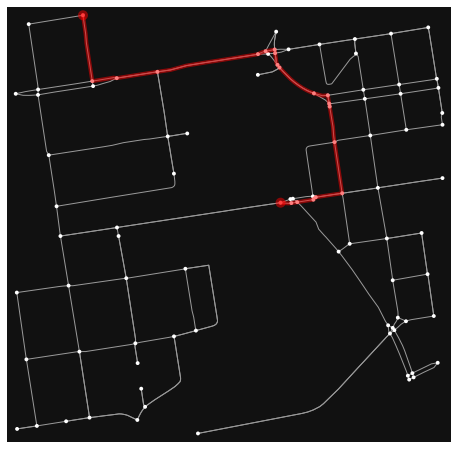

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# Lasketaan lyhin reitti pisteiden välillä käyttäen tieverkostoamme. Huom. jos haluat vaihtaa lähtö- tai loppupisteen, tarvitset pisteiden "osmid"-sarakkeessa olevan lukuarvon.
route = ox.shortest_path(G=graph, orig=orig_node, dest=dest_node, weight='length')

ox.plot_graph_route(graph, route)

Nyt näemme kartalla laskemamme lyhimmän reitin valitsemiemme pisteiden välillä! Kokeile itse selvittää lyhin reitti joidenkin muiden pisteiden välillä! Lyhin reitti on tässä laskettu ainoastaan etäisyyksien perusteella. Voisivatko esimerkiksi nopeusrajoitukset vaikuttaa tulokseen?